In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import cointegration_mult as mult
import Cointegration as coint

importlib.reload(coint)
importlib.reload(mult)

<module 'cointegration_mult' from 'D:\\trades\\pairs_trading_b3\\cointegration_mult.py'>

In [57]:
dataset_meta = 'datasets/dataset_meta.csv'

In [58]:
data = pd.read_csv(dataset_meta)

In [59]:
del data['DateTime']

In [60]:
data.isnull().values.sum()

0

In [63]:
pairs = mult.find_pairs(data,per_sort_reverse=False)
mult.apply_periods(data, pairs)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [64]:
pairs

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,Std,PeriodQt,PeriodStr
0,100,ABEV3,AZUL4,-5.108442,99,0.114604,0.666117,3,"100,120,140"
1,100,ABEV3,B3SA3,-4.089454,99,0.072791,1.426304,3,"100,120,140"
2,100,ABEV3,BBAS3,-4.892879,99,0.121621,1.161896,3,"100,120,140"
3,100,ABEV3,BBDC4,-4.783737,99,0.194603,0.578451,5,"100,120,140,220,240"
4,100,ABEV3,BBSE3,-4.726984,99,0.113935,0.407114,3,"100,120,140"
...,...,...,...,...,...,...,...,...,...
2291,140,VALE3,YDUQ3,-3.067822,95,0.492445,0.274161,7,"140,160,180,200,220,240,250"
2292,120,VIVT4,VVAR3,-3.226217,95,0.359484,1.600094,5,"120,140,160,220,250"
2293,140,VIVT4,WEGE3,-3.379351,95,0.083857,1.275025,2,"140,160"
2294,120,VIVT4,YDUQ3,-3.331518,95,-0.063875,1.125197,6,"120,140,160,220,240,250"


In [62]:
pairs_signal = pairs.loc[
    (pairs['Std'] > 2) \
    & (pairs['Std'] <= 2.5) \
    & (pairs['ADF'] >= 99) \
].copy()
pairs_signal.reset_index(drop=True, inplace=True)
pairs_signal

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,Std
0,100,ABEV3,IRBR3,-4.795174,99,0.205495,2.173091
1,100,AZUL4,NTCO3,-3.635358,99,-0.244980,2.123648
2,120,BBAS3,IRBR3,-3.556378,99,1.455749,2.310149
3,100,BBDC4,ELET3,-3.684713,99,0.157300,2.235241
4,100,BBDC4,ELET6,-3.716351,99,0.171252,2.236074
...,...,...,...,...,...,...,...
64,100,RAIL3,SUZB3,-4.128082,99,-0.074468,2.442986
65,100,RAIL3,TIMP3,-3.970941,99,0.769735,2.141651
66,100,RAIL3,TOTS3,-3.782723,99,0.230241,2.345595
67,100,RAIL3,VIVT4,-3.680103,99,0.379468,2.476402


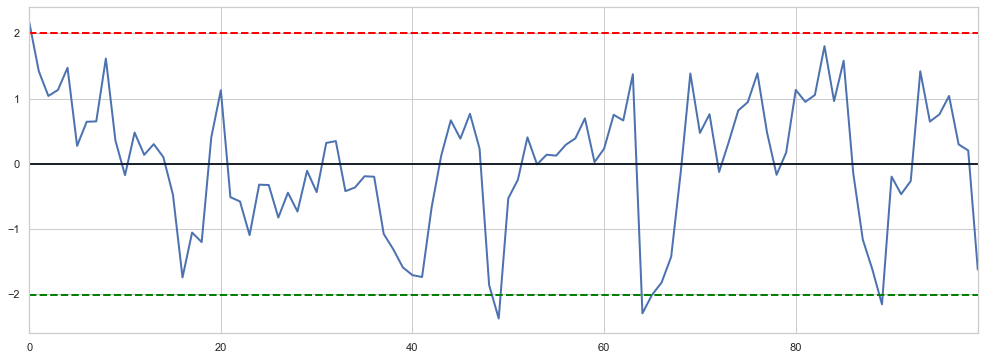

In [52]:
mult.plot_residue(mult.residue(data['ABEV3'], data['IRBR3'], 100))

In [2]:
def loss_own(y, x, volume, period, desv_stop=3.1, price_input_test=0, y_short=True):
    y_test = y.copy()
    x_test = x.copy()
    
    volume = abs(volume)
    if (price_input_test <= 0):
        price_input_test=y_test[0]
    
    price_stop_loss, residue = loss_own_residue(y_test, x_test, period, desv_stop=desv_stop, y_short=y_short)
    return -abs(((price_input_test*volume)-(price_stop_loss*volume)))

def loss_own_residue(y, x, period, desv_stop=3.1, y_short=True):
    y_test = y.copy()
    x_test = x.copy()
    
    last_price = y_test[0].copy()
    penny = 0
    while (True):
        penny=round(penny + 0.01, 2)
        if (y_short):
            y_test[0] = last_price + penny
        else:
            y_test[0] = last_price - penny

        residue = mult.zscore(mult.residue(y_test, x_test, period))
        if(abs(residue[0]) >= desv_stop):
            break
    return y_test[0], residue

def gain_own(y, x, volume, period, price_input_test=0, y_short=True):
    y_test = y.copy()
    x_test = x.copy()
    
    volume = abs(volume)
    if (price_input_test <= 0):
        price_input_test=y_test[0]
    
    price_take_profit, residue = gain_own_residue(y_test, x_test, period, y_short=y_short)
    return abs(((price_input_test*volume)-(price_take_profit*volume)))

def gain_own_residue(y, x, period, y_short=True):
    y_test = y.copy()
    x_test = x.copy()
    
    last_price = y_test[0].copy()
    penny = 0
    while (True):
        penny=round(penny + 0.01, 2)
        if (y_short):
            y_test[0] = last_price - penny
            residue = mult.zscore(mult.residue(y_test, x_test, period))
            if(residue[0] <= 0):
                break
        else:
            y_test[0] = last_price + penny
            residue = mult.zscore(mult.residue(y_test, x_test, period))
            if(residue[0] >= 0):
                break

    return y_test[0], residue

In [3]:
path_data_cart = 'datasets/data_cart.csv'
path_data_yahoo = 'datasets/data_yahoo_adj.csv'
path_data = 'datasets/data.csv'

In [4]:
data = pd.read_csv(path_data_yahoo, index_col=0)
data = data[::-1]
pairs = pd.read_csv('datasets/cointegrated_pairs_mult.csv')

print('{} to {}'.format(data.index[-1], data.index[0]))
print('data: {}'.format(data.shape))
print('pairs: {}'.format(pairs.shape))

2019-05-02 to 2020-07-30
data: (311, 72)
pairs: (2159, 12)


In [5]:
"""y_symbol = 'ELET3'
x_symbol = 'PCAR3'"""

"""y_symbol = 'CMIG4'
x_symbol = 'ENGI11'"""

y_symbol = 'BRKM5'
x_symbol = 'LAME4'

y = data[y_symbol]
x = data[x_symbol]

In [9]:
residues[0]

-2.28343989003074

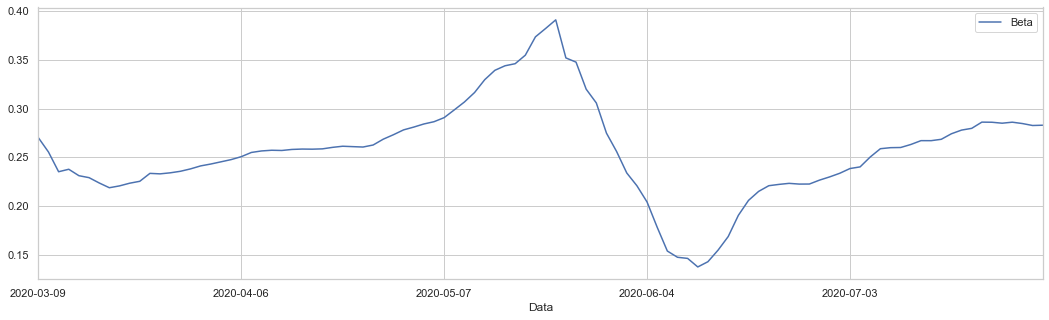

In [8]:
looping = -1
n_recored = 100
period = 50
rows=[]
test=[]
while (looping < (n_recored-1)):
    looping+=1
    dataset = data[looping:]
    y, x = mult.get_values(dataset['CIEL3'], dataset['ITUB4'], period)
    
    coef = mult.coefficients(y, x, period)
    beta = coef['angular']
    beta = coint.beta(y, x)
    
    rows.append([dataset.index[0], beta])
    test.append([looping, y.index[0], y.index[-1], beta])

rolling_beta = pd.DataFrame(rows, columns=['Data', 'Beta'])
rolling_beta.set_index("Data", inplace = True)
rolling_beta[::-1].plot(figsize=(18, 5))
#mult.zscore(rolling_beta[::-1]).plot(figsize=(18, 5))

In [15]:
#rolling_beta

In [16]:
mult.coefficients(data['ENGI11'], data['RENT3'], 250)

{'temp': -0.001969899700550911,
 'angular': 0.6768165731215234,
 'intercept': 20.569156818126967}

In [9]:
test[0:20]

[[0, '2020-07-30', '2020-05-21', 0.2828778671826724],
 [1, '2020-07-29', '2020-05-20', 0.2825895514207069],
 [2, '2020-07-28', '2020-05-19', 0.28458835799825777],
 [3, '2020-07-27', '2020-05-18', 0.285987973530931],
 [4, '2020-07-24', '2020-05-15', 0.28494463938512116],
 [5, '2020-07-23', '2020-05-14', 0.28592096656967547],
 [6, '2020-07-22', '2020-05-13', 0.2860491885744251],
 [7, '2020-07-21', '2020-05-12', 0.279658915961006],
 [8, '2020-07-20', '2020-05-11', 0.27787815551449047],
 [9, '2020-07-17', '2020-05-08', 0.2741090210348377],
 [10, '2020-07-16', '2020-05-07', 0.26842500583579587],
 [11, '2020-07-15', '2020-05-06', 0.2670180916239293],
 [12, '2020-07-14', '2020-05-05', 0.2670429129195572],
 [13, '2020-07-13', '2020-05-04', 0.26310026180249146],
 [14, '2020-07-10', '2020-04-30', 0.26001347150661114],
 [15, '2020-07-09', '2020-04-29', 0.2598334606955248],
 [16, '2020-07-08', '2020-04-28', 0.2587660295096111],
 [17, '2020-07-07', '2020-04-27', 0.25029012909878173],
 [18, '2020-07